In [1]:
import meteostat
from datetime import datetime 

maine_stations = meteostat.Stations().region("US", "ME").fetch().sort_values(by=["daily_start"])
maine_stations = maine_stations[maine_stations["daily_start"] < maine_stations["daily_start"].mean()]
print(maine_stations[["name", "daily_start", "daily_end"]])

# Determine the maximum year range:
start_year = min([datetime.fromisoformat(str(df["daily_start"])).year for _, df in maine_stations.iterrows()])
end_year = max([datetime.fromisoformat(str(df["daily_end"])).year for _, df in maine_stations.iterrows()])

                                      name daily_start  daily_end
id                                                               
72608                             Eastport  1889-09-01 2013-04-19
72619                           Greenville  1920-01-01 2024-12-04
72712            Caribou Municipal Airport  1939-01-16 2024-12-30
74392              Brunswick Naval Air Stn  1940-09-01 2010-02-07
72606      Portland International  Jetport  1940-11-07 2024-12-30
72713                         Presque Isle  1941-11-02 2022-04-25
KMLT0           Millinocket / Little Italy  1943-03-02 2022-04-24
72607  Bangor / Martells Mobile Home Court  1953-01-01 2024-12-30
KAUG0                              Augusta  1973-01-01 2022-04-24


# Heating Degree Days (HDD)

Heating Degree Days (HDD) is a metric used to quantify the energy demand for heating buildings. It is calculated by subtracting the average daily temperature from a base temperature, typically 65°F (18°C). If the resulting difference is positive, it indicates a heating demand, and the value is added to the cumulative HDD for that period. A higher HDD value signifies colder weather and increased energy consumption for heating. HDD data is valuable for various applications including energy forecasting and building energy efficiency analysis.

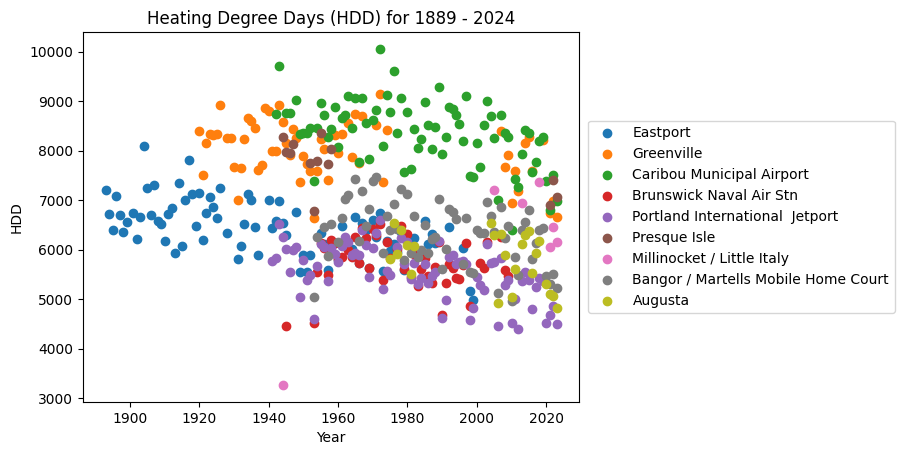

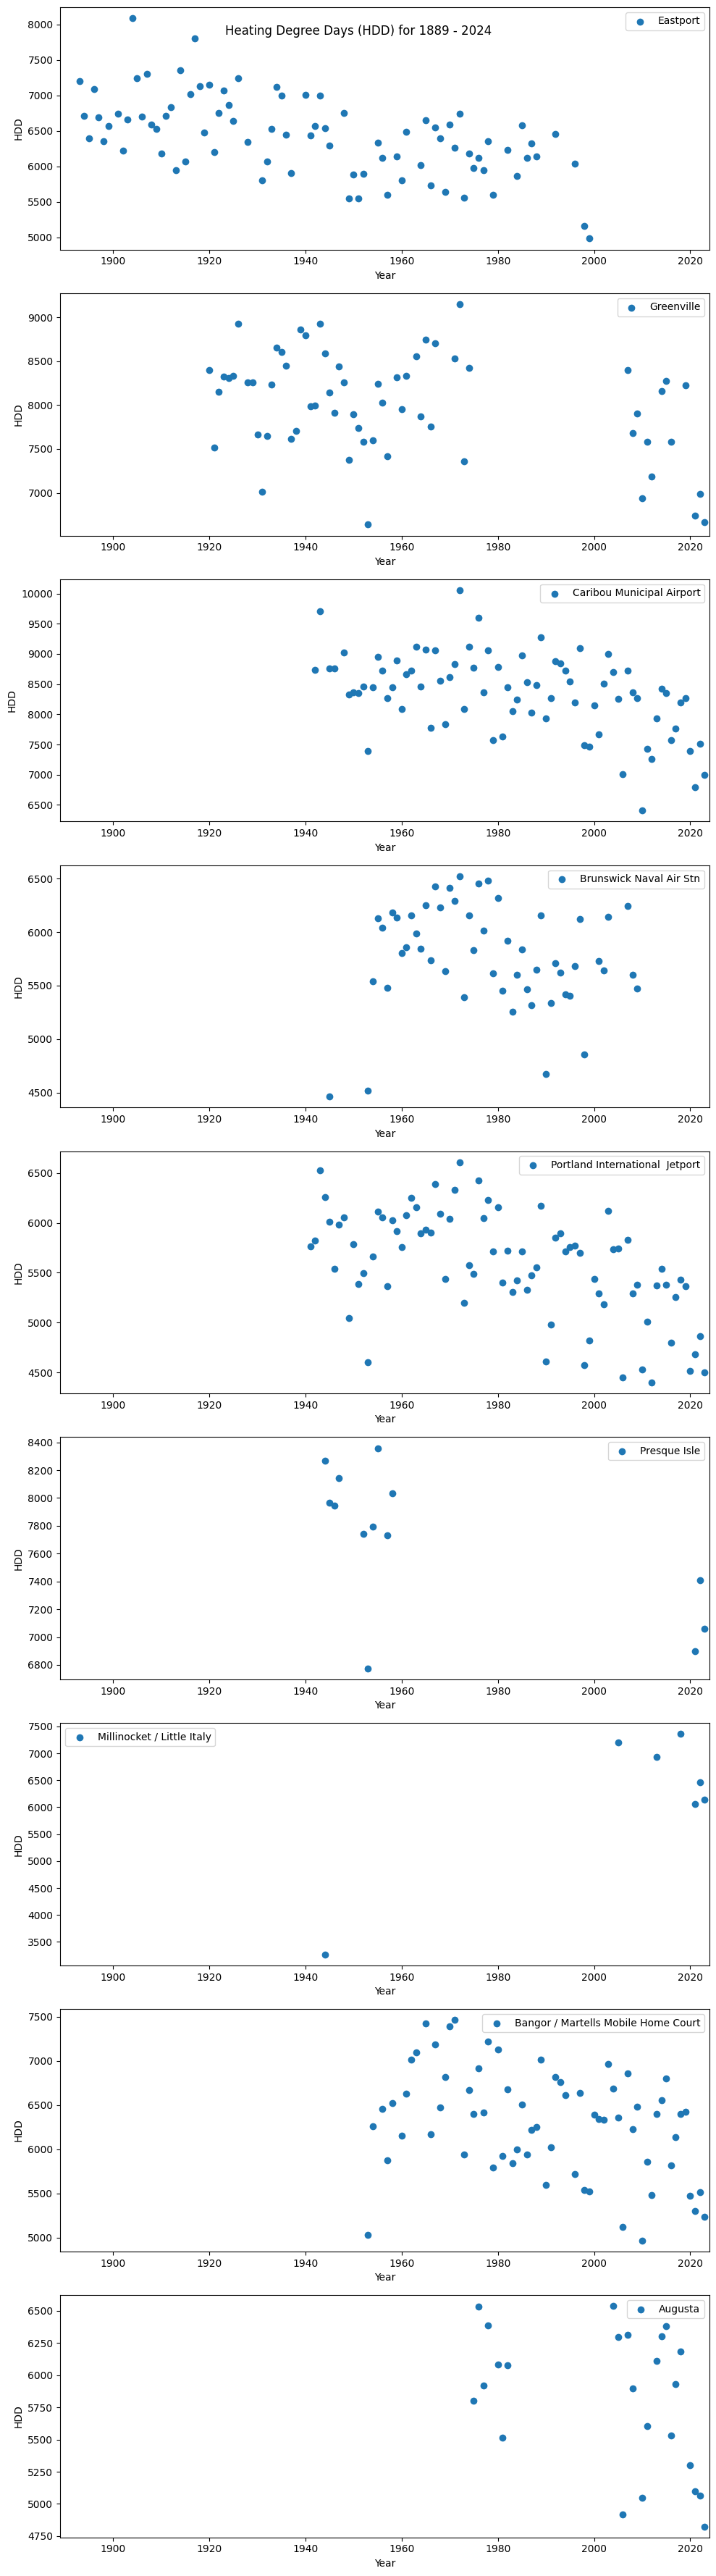

In [2]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def annual_hdd_for_station(
    station: str,
    year: int
):
    data = meteostat.Daily(
        start=datetime(year,1,1),
        end= datetime(year, 12, 31),
        loc= station
    ).fetch()
    
    # Only run the calculation if we have a complete annual dataset
    if not (data.shape[0] == 365 or data.shape[0] == 366):
        return None

    # Average daily temperature can be estimated as average of the daily min and max
    # We will overwrite any recorded average with this value for consistency
    data["tavg"] = data["tmax"] + data["tmin"] / 2.
    
    # HDD requires conversion to degrees F
    data["tavg_f"] = data["tavg"]*1.8 + 32.
    data["hdd"] = np.where(data["tavg_f"] <=65., 65. - data["tavg_f"], 0.)
    
    return data["hdd"].sum()

annual_hdd = pd.DataFrame(index=list(range(start_year, end_year)))

for station, df in maine_stations.iterrows():
    annual_hdd[station] = [annual_hdd_for_station(station, year) for year in range(start_year, end_year)]
    annual_hdd[station] = annual_hdd[station].replace(0, None)
    
# Plot all data in sigle plot
for col in annual_hdd.columns.tolist():
    plt.scatter(annual_hdd.index.to_numpy(), annual_hdd[col].to_numpy(), label=maine_stations.loc[col]["name"])
    plt.xlabel("Year")
    plt.ylabel("HDD")
    plt.legend(bbox_to_anchor=(1.65, 0.5), loc='center right')
    
plt.title(f"Heating Degree Days (HDD) for {start_year} - {end_year}")
plt.show()

# Plot each series
fig, axes = plt.subplots(nrows= len(annual_hdd.columns), figsize=(10, 4* len(annual_hdd.columns)))
for i, col in enumerate(annual_hdd.columns):
    ax = axes[i]
    ax.scatter(annual_hdd.index.to_numpy(), annual_hdd[col].to_numpy(), label=maine_stations.loc[col]["name"])
    ax.set_xlabel("Year")
    ax.set_xlim(start_year, end_year)
    ax.set_ylabel("HDD")
    ax.legend()

# Adjust layout and display the plot
fig.suptitle(f"Annual Heating Degree Days (HDD) for {start_year} - {end_year}")
plt.tight_layout()
plt.show()
annual_hdd.to_csv("simple_hdd.csv")

# Heating Degree Days sliced by Month

In [28]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def monthly_hdd_for_station(
    station: str,
    year: int
):
    data = meteostat.Daily(
        start=datetime(year,1,1),
        end= datetime(year, 12, 31),
        loc= station
    ).fetch()
    
    # Only run the calculation if we have a complete annual dataset
    if not (data.shape[0] == 365 or data.shape[0] == 366):
        return None

    # Average daily temperature can be estimated as average of the daily min and max
    # We will overwrite any recorded average with this value for consistency
    data["tavg"] = data["tmax"] + data["tmin"] / 2.
    
    # HDD requires conversion to degrees F
    data["tavg_f"] = data["tavg"]*1.8 + 32.
    data["hdd"] = np.where(data["tavg_f"] <=65., 65. - data["tavg_f"], 0.)
    
    data = data.resample("ME").agg(
        {
            "hdd" : "sum"
        }
    )["hdd"]
    return data



monthly_hdd = {}
for station, df in maine_stations.iterrows():
    df = pd.concat([monthly_hdd_for_station(station, year) for year in range(start_year, end_year)], axis=0)
    df = df.replace(0, None)
    df = (df - df.mean())/df.std()
    monthly_hdd[station] = df

monthly_dataframes = {}
for month in range(1, 13):
    monthly_df = pd.DataFrame()
    for station, data in monthly_hdd.items():
        monthly_data = data[data.index.month == month]
        monthly_df[station] = monthly_data
    
    # Add the monthly DataFrame to the dictionary
    monthly_dataframes[month] = monthly_df


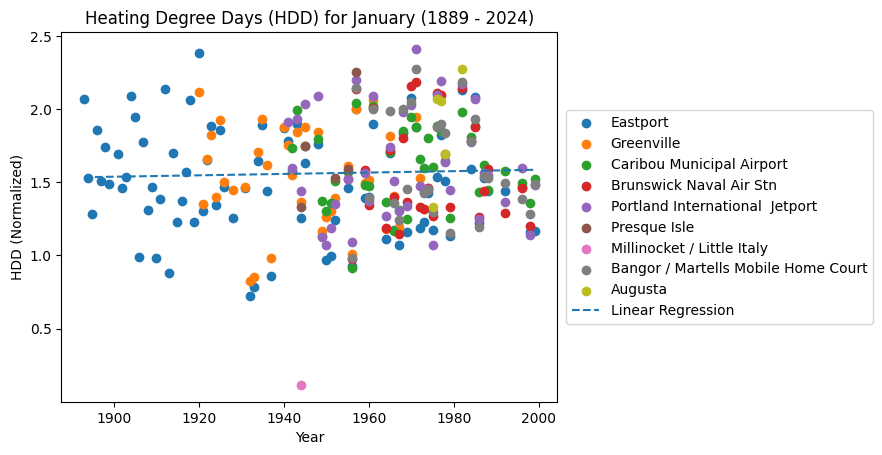

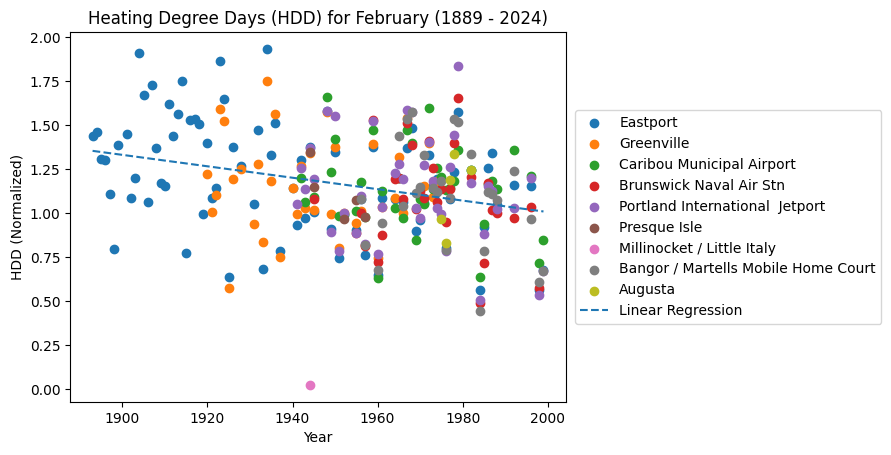

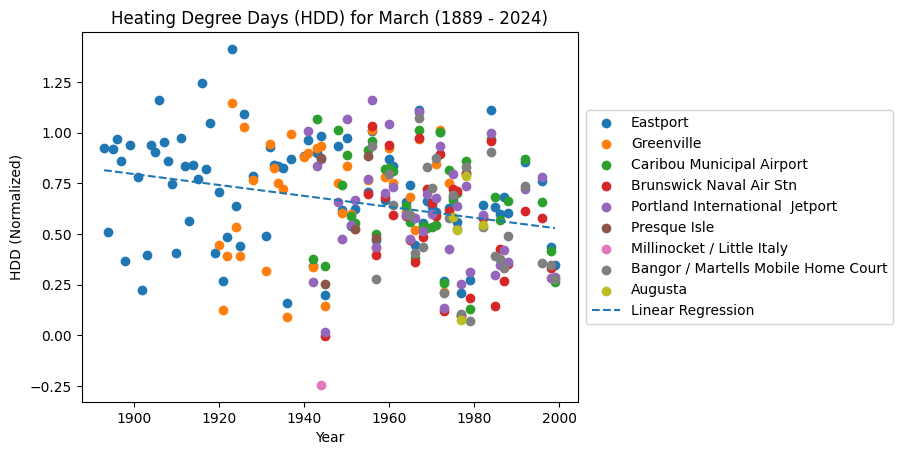

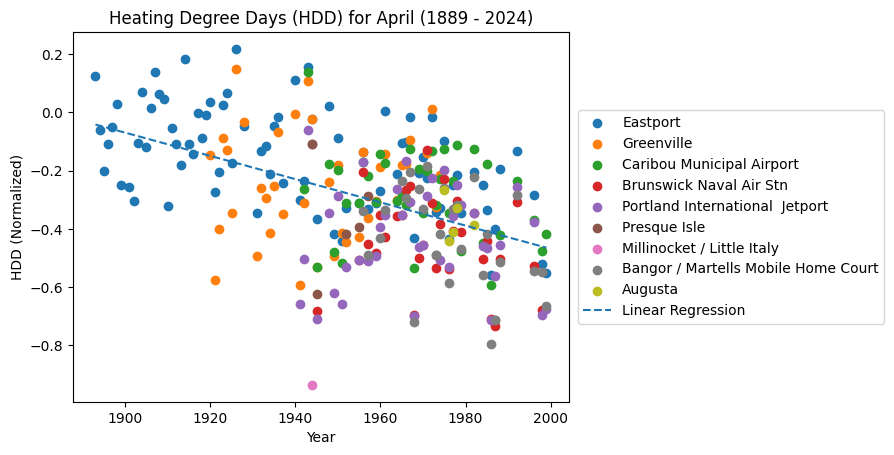

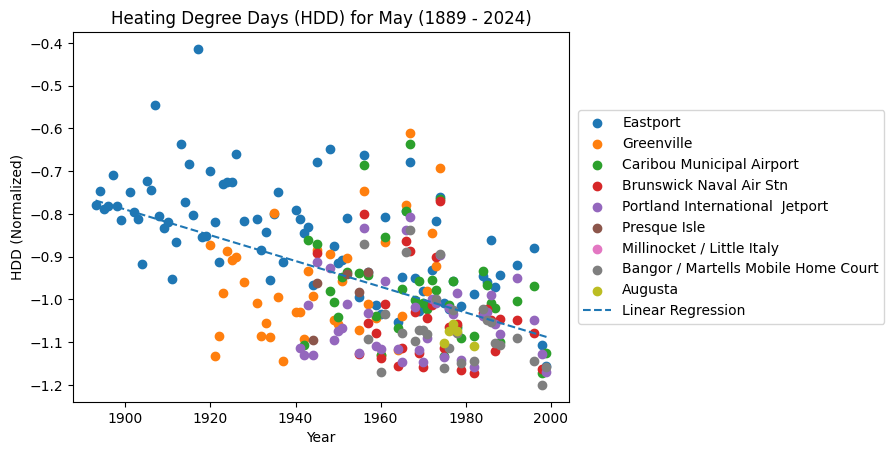

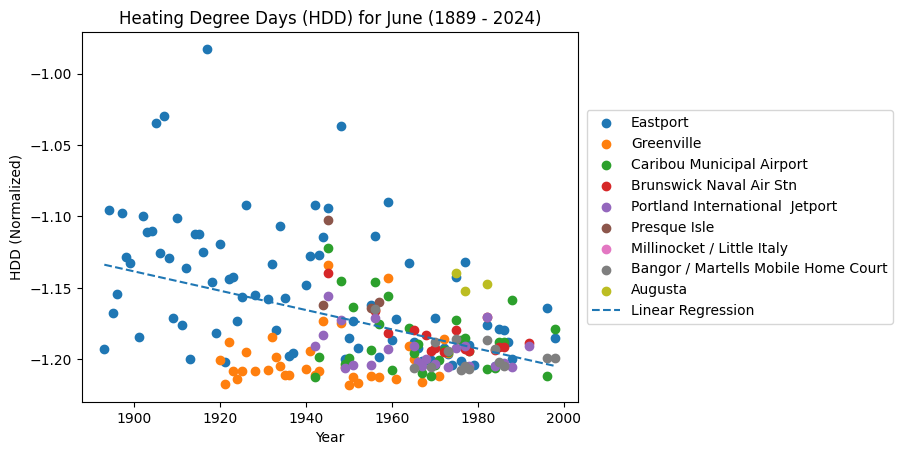

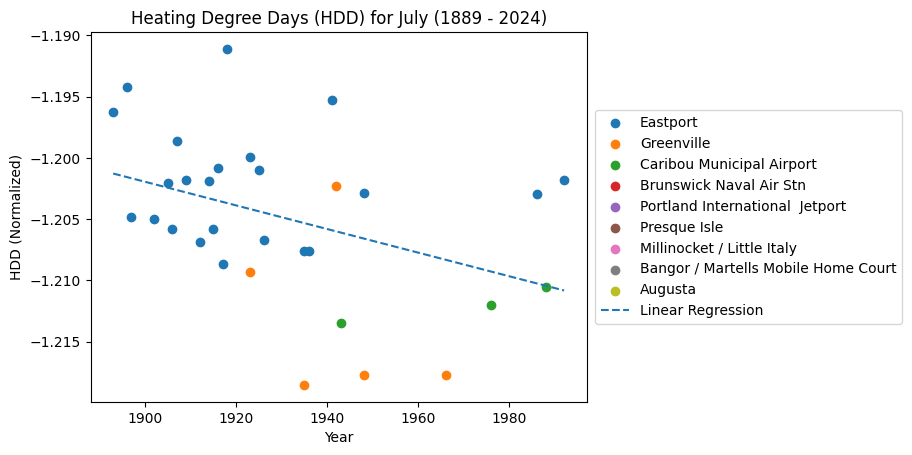

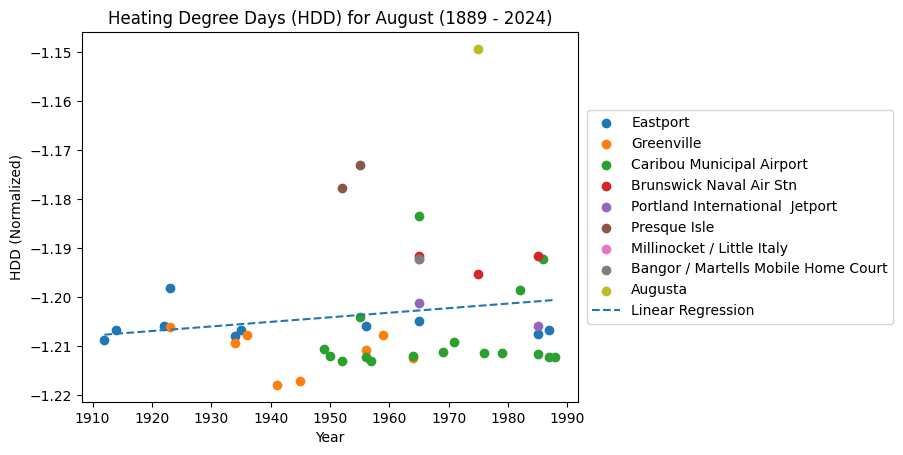

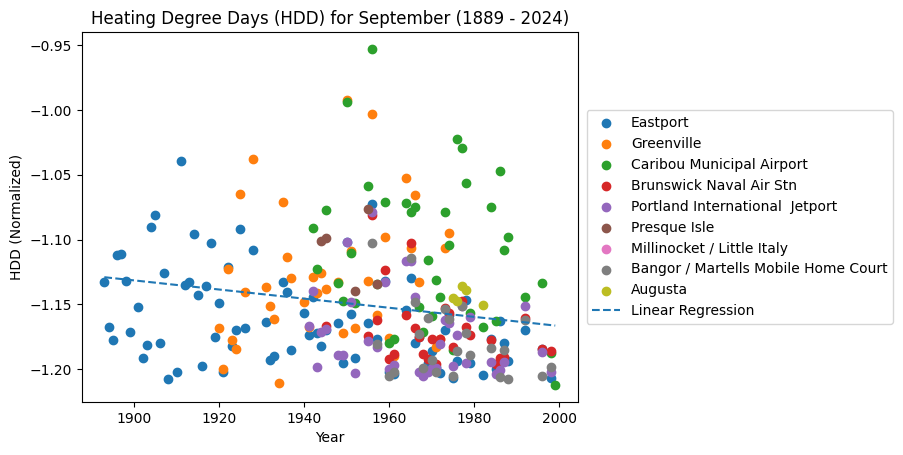

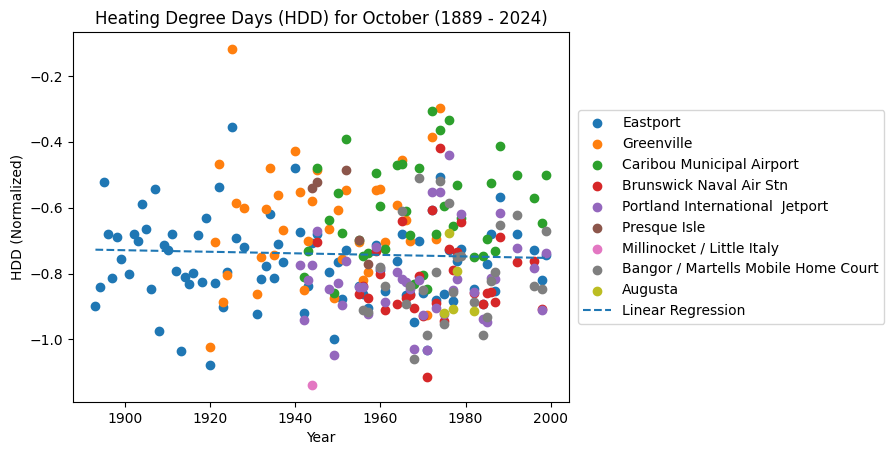

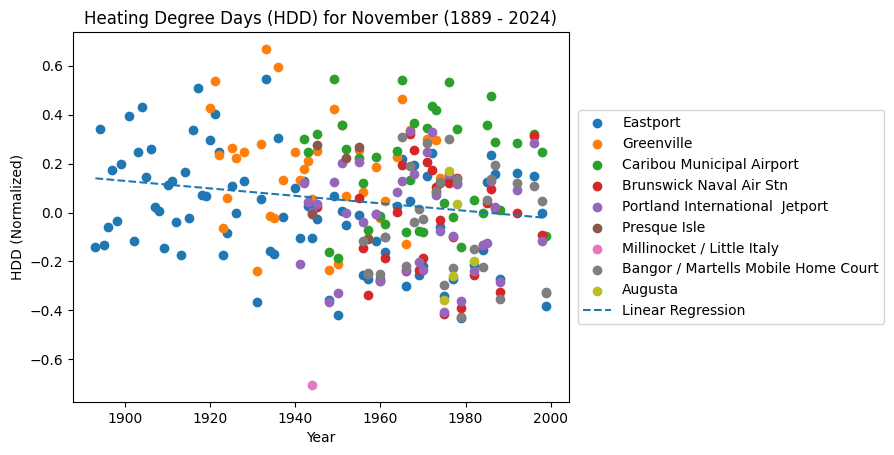

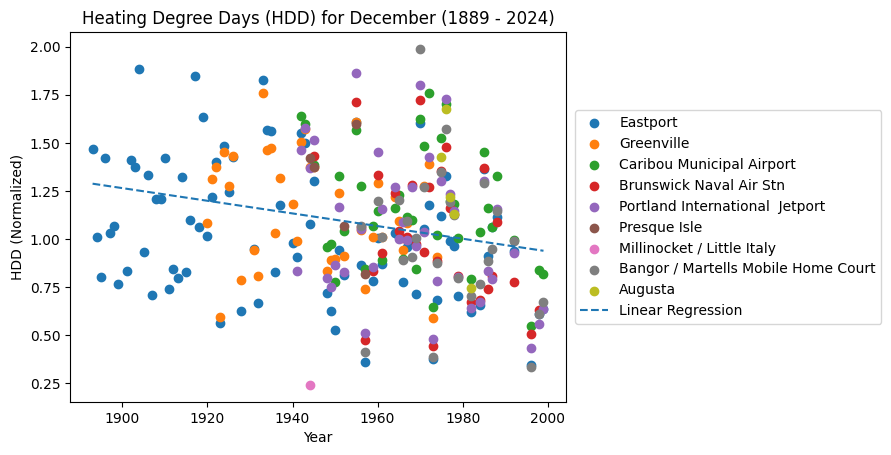

                               January                 February  \
coefficients  [0.00047689754917005426]  [-0.003250038959154807]   
r_squared                     0.001135                 0.079957   
stdev                         0.355877                 0.288639   
mse                           0.126505                 0.076651   
root_mse                      0.355675                 0.276859   

                                 March                    April  \
coefficients  [-0.0026964776017654934]  [-0.003988532771638954]   
r_squared                      0.06048                 0.238311   
stdev                         0.275349                  0.20518   
mse                           0.071232                 0.032066   
root_mse                      0.266892                  0.17907   

                                   May                      June  \
coefficients  [-0.0030106694431361915]  [-0.0006752518853797837]   
r_squared                     0.291899                  0.

In [45]:
# Plot each series
months = {
    1: "January",
    2: "February",
    3: "March",
    4: "April",
    5: "May",
    6: "June",
    7: "July",
    8: "August",
    9: "September",
    10: "October",
    11: "November",
    12: "December"
}

trends = {}
for i, month in enumerate(monthly_dataframes.keys()):
    df = monthly_dataframes[month]
    x = []
    y = []
    for j, station in enumerate(df.columns):
        dx = [int(idx.year) for idx in df.index.to_list()]
        x = np.concatenate([x, dx]).astype(float)
        y = np.concatenate([y, df[station].to_numpy()]).astype(float)
        plt.scatter(dx, df[station].to_numpy(), label=maine_stations.loc[station]["name"])


    # Cull Nan values from np arrays
    nan_indices = np.where(np.isnan(y))[0]
    x = np.delete(x, nan_indices)
    y = np.delete(y, nan_indices)

    # Linear regression
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    correlation_matrix = np.corrcoef(y, p(x))
    r_squared = correlation_matrix[0, 1] ** 2
    mse = np.mean((y - p(x))**2)
    rmse = np.sqrt(mse)
    trends[months[month]] = {
        "coefficients": p,
        "r_squared": r_squared,
        "stdev": np.std(y),
        "mse": mse,
        "root_mse": rmse
    }

    xp = np.linspace(np.min(x), np.max(x), 10)
    plt.plot(xp, p(xp), '--', label="Linear Regression")
    plt.xlabel("Year")
    plt.ylabel("HDD (Normalized)")
    plt.title(f"Heating Degree Days (HDD) for {months[month]} ({np.min(x)} - {np.max(x)})")
    plt.legend(bbox_to_anchor=(1.65, 0.5), loc='center right')
    plt.show()


trends = pd.DataFrame(trends)
print(trends)

